# Tourism-Large data DeepAR

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/AustralianDomesticTourism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In many cases, only the time series at the lowest level of the hierarchies (bottom time series) are available. `HierarchicalForecast` has tools to create time series for all hierarchies. In this notebook we will see how to do it.

In [1]:

# compute base forecast no coherent
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive
import pandas as pd

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut
from datasetsforecast.hierarchical import HierarchicalData
import numpy as np
from statsforecast.models import ETS


/home/arindam/anaconda3/envs/kdd23/lib/python3.9/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Aggregate bottom time series

In this example we will use the [Tourism](https://otexts.com/fpp3/tourism.html) dataset from the [Forecasting: Principles and Practice](https://otexts.com/fpp3/) book. The dataset only contains the time series at the lowest level, so we need to create the time series for all hierarchies.

In [2]:
# Load TourismSmall dataset
Y_df, S, tags = HierarchicalData.load('./data', 'TourismLarge')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [3]:
Y_df

,unique_id,ds,y
0,TotalAll,1998-01-01,45151.071280
1,TotalAll,1998-02-01,17294.699551
2,TotalAll,1998-03-01,20725.114184
3,TotalAll,1998-04-01,25388.612353
4,TotalAll,1998-05-01,20330.035211
...,...,...,...
126535,GBDOth,2016-08-01,0.000000
126536,GBDOth,2016-09-01,0.000000
126537,GBDOth,2016-10-01,0.000000
126538,GBDOth,2016-11-01,0.000000


In [4]:
unq_ids = Y_df["unique_id"].unique()
num_series = len(unq_ids)
num_series

555

In [5]:
len_series = len(Y_df[Y_df["unique_id"] == unq_ids[0]])
len_series

228

In [6]:
S

,AAAHol,AAAVis,AAABus,AAAOth,AABHol,AABVis,AABBus,AABOth,ABAHol,ABAVis,...,GBBBus,GBBOth,GBCHol,GBCVis,GBCBus,GBCOth,GBDHol,GBDVis,GBDBus,GBDOth
TotalAll,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AAll,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAll,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAll,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DAll,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GBCOth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
GBDHol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
GBDVis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
GBDBus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
tags

{'Country': array(['TotalAll'], dtype=object),
 'Country/State': array(['AAll', 'BAll', 'CAll', 'DAll', 'EAll', 'FAll', 'GAll'],
       dtype=object),
 'Country/State/Zone': array(['AAAll', 'ABAll', 'ACAll', 'ADAll', 'AEAll', 'AFAll', 'BAAll',
        'BBAll', 'BCAll', 'BDAll', 'BEAll', 'CAAll', 'CBAll', 'CCAll',
        'CDAll', 'DAAll', 'DBAll', 'DCAll', 'DDAll', 'EAAll', 'EBAll',
        'ECAll', 'FAAll', 'FBAll', 'FCAll', 'GAAll', 'GBAll'], dtype=object),
 'Country/State/Zone/Region': array(['AAAAll', 'AABAll', 'ABAAll', 'ABBAll', 'ACAAll', 'ADAAll',
        'ADBAll', 'ADCAll', 'ADDAll', 'AEAAll', 'AEBAll', 'AECAll',
        'AEDAll', 'AFAAll', 'BAAAll', 'BABAll', 'BACAll', 'BBAAll',
        'BCAAll', 'BCBAll', 'BCCAll', 'BDAAll', 'BDBAll', 'BDCAll',
        'BDDAll', 'BDEAll', 'BDFAll', 'BEAAll', 'BEBAll', 'BECAll',
        'BEDAll', 'BEEAll', 'BEFAll', 'BEGAll', 'BEHAll', 'CAAAll',
        'CABAll', 'CACAll', 'CBAAll', 'CBBAll', 'CBCAll', 'CBDAll',
        'CCAAll', 'CCBAll', 'CC

In [8]:
len(tags.keys())

8

### Split Train/Test sets

We use the final horizon as test set.

In [9]:
HORIZON = 12
FREQUENCY = "1M"

In [10]:
Y_test_df = Y_df.groupby('unique_id').tail(HORIZON)
Y_train_df = Y_df.drop(Y_test_df.index)

In [11]:
Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

In [12]:
Y_train_df.groupby('unique_id').size()

unique_id
AAAAll      216
AAABus      216
AAAHol      216
AAAOth      216
AAAVis      216
           ... 
TotalAll    216
TotalBus    216
TotalHol    216
TotalOth    216
TotalVis    216
Length: 555, dtype: int64

## Computing base forecasts

The following cell computes the **base forecasts** for each time series in `Y_df` using the `auto_arima` and `naive` models. Observe that `Y_hat_df` contains the forecasts but they are not coherent.

In [13]:
# Convert train df to gluonts format
# from data_utils import convert_df_to_gluonts_iter

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

def convert_df_to_gluonts_iter(df: pd.DataFrame, horizon: int, frequency: str):

    unq_ids = np.unique(df.index)

    all_ts = []
    for id_ in unq_ids:
        df_one_ts = df[df.index == id_].sort_values("ds")
        start_time = df_one_ts["ds"][0]
        target_vals = df_one_ts["y"].values
        # print(id_, start_time, target_vals)
        all_ts.append(
            {
                FieldName.TARGET: target_vals,
                FieldName.START: start_time,
                FieldName.ITEM_ID: id_
            }
        )
    return ListDataset(all_ts, freq=frequency)

gluon_dset_train = convert_df_to_gluonts_iter(Y_train_df, HORIZON, FREQUENCY)
gluon_dset_test = convert_df_to_gluonts_iter(Y_df.set_index('unique_id'), HORIZON, FREQUENCY)

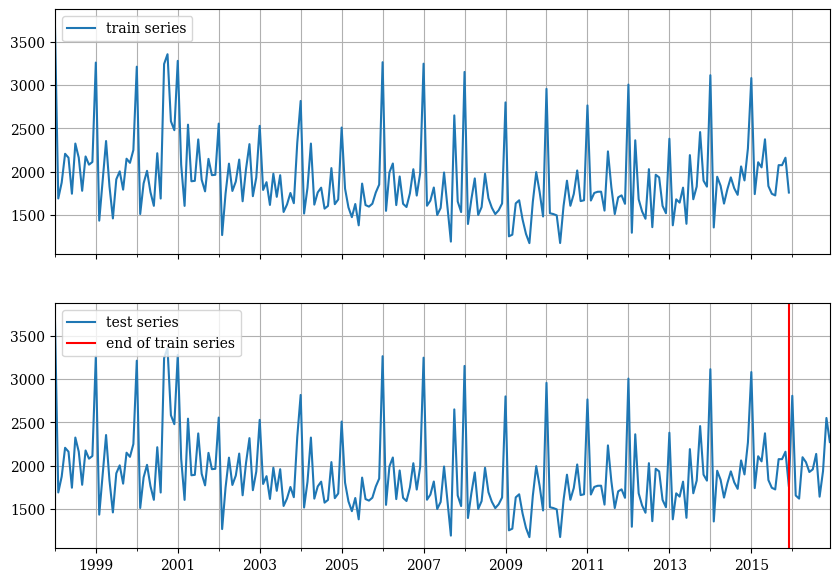

In [14]:
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas

train_entry = next(iter(gluon_dset_train))
test_entry = next(iter(gluon_dset_test))

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")  # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()



In [15]:

from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

CONTEXT_LEN = 2 * HORIZON
EPOCHS = 10
FREQ = FREQUENCY
LR = 1e-3
BATCHES_PER_EPOCH = 100

estimator = DeepAREstimator(
    freq=FREQ,
    prediction_length=HORIZON,
    trainer=Trainer(ctx="cpu", epochs=EPOCHS, learning_rate=1e-3, num_batches_per_epoch=BATCHES_PER_EPOCH),
    context_length=CONTEXT_LEN,
    scaling=True
)

predictor = estimator.train(gluon_dset_train)

# # Fit and predict with N-BEATS and N-HiTS models
# models = [NBEATS(input_size=CONTEXT_LEN, h=HORIZON, max_epochs=EPOCHS)]
# fcst = NeuralForecast(models=models, freq='M')
# fcst.fit(df=Y_train_df)

INFO:gluonts.mx.context:Using CPU
/home/arindam/anaconda3/envs/kdd23/lib/python3.9/site-packages/gluonts/model/deepar/__init__.py:18: FutureWarning: The module gluonts.model.deepar has been moved to gluonts.mx.model.deepar. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import DeepAREstimator'.
  warnings.warn(
INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.28it/s, epoch=1/10, avg_epoch_loss=5.24]
INFO:gluonts.trainer:Epoch[0] Elapsed time 12.097 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=5.239422
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.18it/s, epoch=2/10, avg_epoch_loss=5.02]
INFO:gluonts.trainer:Epoch[1] Elapsed time 10.898 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=5.021525
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████

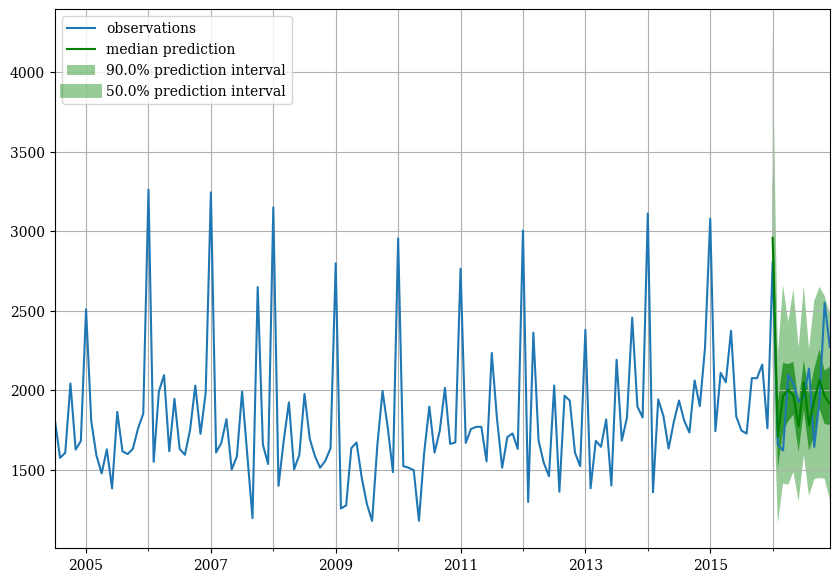

In [16]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=gluon_dset_test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]
plot_prob_forecasts(ts_entry, forecast_entry)

### Convert the forecasts iterator into pandas df

In [17]:
def convert_gluonts_iter_to_df(
    gluon_iter,
    test_dates
):
    out = []
    dates = []
    ids = []
    for x in gluon_iter:
        ids.extend([x.item_id]*HORIZON)
        out.extend(np.mean(x.samples, axis=0).reshape(-1))
        dates.extend(test_dates)
    out = pd.DataFrame({"unique_id": ids, "ds": dates, "y_hat": out})
    out = out.set_index("unique_id")
    return out

test_dates = Y_test_df["ds"].unique()
test_dates.sort()
forecast_df = convert_gluonts_iter_to_df(forecasts, test_dates)
print(forecast_df)

                  ds        y_hat
unique_id                        
AAAAll    2016-01-01  3015.255859
AAAAll    2016-02-01  1737.135010
AAAAll    2016-03-01  1979.452515
AAAAll    2016-04-01  1967.535156
AAAAll    2016-05-01  2023.567505
...              ...          ...
TotalVis  2016-08-01  7190.106445
TotalVis  2016-09-01  7087.240723
TotalVis  2016-10-01  8451.602539
TotalVis  2016-11-01  7607.393555
TotalVis  2016-12-01  8416.286133

[6660 rows x 2 columns]


### Computing in-sample forecasts needed for MinT, ERM methods
Note that the model is already trained on the training part of the data. Now, the in-sample forecasts are obtained by a moving window method. These in-sample forecasts are needed to estimate the residual covariance matrix in MinT and ERM methods.

In [18]:
dates = Y_df.ds.unique()
dates.sort()
dates_train = Y_train_df.ds.unique()
dates_train.sort()
Y_hat_in_sample = None
for i in range(0, len(dates_train)-HORIZON-CONTEXT_LEN+1):
    # print(i, i+CONTEXT_LEN, i+CONTEXT_LEN+HORIZON)
    backtest_history = Y_train_df[(Y_train_df.ds >= dates[i]) & (Y_train_df.ds < dates[i+CONTEXT_LEN])]
    end_pt = i+CONTEXT_LEN+HORIZON
    if end_pt < len(dates_train):
        backtest_test_true = Y_train_df[(Y_train_df.ds >= dates[i+CONTEXT_LEN]) & (Y_train_df.ds < dates[end_pt])]
    else:
        backtest_test_true = Y_train_df[(Y_train_df.ds >= dates[i+CONTEXT_LEN])]
    # print(len(backtest_test_true))
    backtest_history_iter = convert_df_to_gluonts_iter(backtest_history, HORIZON, FREQUENCY)
    forecast_it, ts_it = make_evaluation_predictions(
                            dataset=backtest_history_iter,  # test dataset
                            predictor=predictor,  # predictor
                            num_samples=100,  # number of sample paths we want for evaluation
                        )
    forecasts = list(forecast_it)
    # Y_hat_in_sample_part = fcst.predict(df=backtest_history)
    test_dates = backtest_test_true["ds"].unique()
    test_dates.sort()
    Y_hat_in_sample_part = convert_gluonts_iter_to_df(forecasts, test_dates)
    # Y_hat_in_sample_part["ds"] = backtest_test_true["ds"].values
    first_horizon_date = backtest_test_true["ds"].unique()[0]
    if Y_hat_in_sample is None:
        Y_hat_in_sample = Y_hat_in_sample_part[Y_hat_in_sample_part["ds"] == first_horizon_date]
    else:
        if i == len(dates_train)-HORIZON-CONTEXT_LEN:
            Y_hat_in_sample = pd.concat([Y_hat_in_sample, Y_hat_in_sample_part])
        else:
            Y_hat_in_sample = pd.concat([Y_hat_in_sample, Y_hat_in_sample_part[Y_hat_in_sample_part["ds"] == first_horizon_date]])

In [19]:
Y_hat_in_sample

,ds,y_hat
unique_id,,
AAAAll,2000-01-01,3098.772461
AAABus,2000-01-01,524.034790
AAAHol,2000-01-01,1132.503906
AAAOth,2000-01-01,153.253479
AAAVis,2000-01-01,1296.827026
...,...,...
TotalVis,2015-08-01,6109.126465
TotalVis,2015-09-01,6718.134766
TotalVis,2015-10-01,7593.796387


## Predict on test

In [20]:
Y_hat_df = forecast_df
Y_hat_df

,ds,y_hat
unique_id,,
AAAAll,2016-01-01,3015.255859
AAAAll,2016-02-01,1737.135010
AAAAll,2016-03-01,1979.452515
AAAAll,2016-04-01,1967.535156
AAAAll,2016-05-01,2023.567505
...,...,...
TotalVis,2016-08-01,7190.106445
TotalVis,2016-09-01,7087.240723
TotalVis,2016-10-01,8451.602539


In [21]:
# Create Y_df with y_hat_in_sample
Y_train_df_extended = Y_train_df.merge(Y_hat_in_sample, on=["ds", "unique_id"], how="inner")
Y_train_df_extended

,ds,y,y_hat
unique_id,,,
TotalAll,2000-01-01,43132.018482,37861.777344
TotalAll,2000-02-01,19147.164629,25241.382812
TotalAll,2000-03-01,21220.661619,25302.023438
TotalAll,2000-04-01,25628.897580,27497.994141
TotalAll,2000-05-01,19754.251967,23527.732422
...,...,...,...
GBDOth,2015-08-01,17.683774,2.049266
GBDOth,2015-09-01,0.000000,3.173715
GBDOth,2015-10-01,0.000000,1.590610


## Reconcile forecasts

The following cell makes the previous forecasts coherent using the `HierarchicalReconciliation` class. Since the hierarchy structure is not strict, we can't use methods such as `TopDown` or `MiddleOut`. In this example we use `BottomUp` and `MinTrace`.

In [22]:
from hierarchicalforecast.methods import BottomUp, MinTrace, ERM

reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols'),
    ERM(method='reg')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df_extended, S=S, tags=tags)

The dataframe `Y_rec_df` contains the reconciled forecasts.

In [23]:
Y_rec_df

,ds,y_hat,y_hat/BottomUp,y_hat/MinTrace_method-mint_shrink,y_hat/MinTrace_method-ols,y_hat/ERM_method-reg_lambda_reg-0.01
unique_id,,,,,,
TotalAll,2016-01-01,45433.121094,39077.207031,53495.833671,45284.653415,56219.578125
TotalAll,2016-02-01,21096.779297,20302.474609,21546.304425,20893.167197,23375.503906
TotalAll,2016-03-01,23524.425781,22399.130859,26592.455468,23526.920351,27406.021484
TotalAll,2016-04-01,28310.068359,25694.839844,31895.655502,28300.680135,33046.011719
TotalAll,2016-05-01,22306.578125,21223.771484,23872.844212,22200.502674,26493.808594
...,...,...,...,...,...,...
GBDOth,2016-08-01,-0.001913,-0.001913,0.477530,0.038613,9.111964
GBDOth,2016-09-01,-0.010195,-0.010195,0.289971,2.395130,9.355335
GBDOth,2016-10-01,-0.062678,-0.062678,-0.300414,2.149928,0.902777


## Evaluation 

The `HierarchicalForecast` package includes the `HierarchicalEvaluation` class to evaluate the different hierarchies and also is capable of compute scaled metrics compared to a benchmark model.

In [24]:
tags.keys()

dict_keys(['Country', 'Country/State', 'Country/State/Zone', 'Country/State/Zone/Region', 'Country/Purpose', 'Country/State/Purpose', 'Country/State/Zone/Purpose', 'Country/State/Zone/Region/Purpose'])

In [25]:
from hierarchicalforecast.evaluation import HierarchicalEvaluation

def rmse(y, y_hat):
    return np.mean(np.sqrt(np.mean((y-y_hat)**2, axis=1)))

def mase(y, y_hat, y_insample, seasonality=4):
    errors = np.mean(np.abs(y - y_hat), axis=1)
    scale = np.mean(np.abs(y_insample[:, seasonality:] - y_insample[:, :-seasonality]), axis=1)
    return np.mean(errors / scale)

def rmsse(y, y_hat, y_insample):
    errors = np.mean(np.square(y - y_hat), axis=1)
    scale = np.mean(np.square(y_insample[:, 1:] - y_insample[:, :-1]), axis=1)
    return np.mean(np.sqrt(errors / scale))

eval_tags = {}
for k in tags.keys():
    eval_tags[k] = tags[k]

evaluator = HierarchicalEvaluation(evaluators=[rmse, mase, rmsse])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,
        tags=eval_tags, Y_df=Y_train_df
)
evaluation = evaluation.drop('Overall')
# evaluation.columns = ['Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
evaluation.columns = ['Base', 'BottomUp', 'MinTrace(ols)', 'MinTrace(mint_shrink)', 'ERM']
evaluation = evaluation.applymap('{:.4f}'.format)

/tmp/ipykernel_2840765/3617059200.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  evaluation = evaluation.drop('Overall')


### RMSE

The following table shows the performance measured using RMSE across levels for each reconciliation method.

In [26]:
score_df = evaluation.query('metric == "rmse"')
score_df

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Country,rmse,1657.7984,3602.2219,2794.3747,1714.4073,4264.7271
Country/State,rmse,445.0190,623.6253,631.3387,434.6771,1016.8196
Country/State/Zone,rmse,185.8364,220.1395,226.6465,187.3433,381.4069
Country/State/Zone/Region,rmse,96.3430,102.0712,106.4922,95.5968,185.6994
Country/Purpose,rmse,771.4486,1137.6190,1253.3396,757.9969,2222.5421
Country/State/Purpose,rmse,194.3923,225.5608,252.3822,194.2086,446.0967
Country/State/Zone/Purpose,rmse,82.9470,86.5129,95.3879,82.1596,165.4333
Country/State/Zone/Region/Purpose,rmse,41.8944,41.8944,45.6210,41.4478,78.9443


### MASE


The following table shows the performance measured using MASE across levels for each reconciliation method.

In [27]:
evaluation.query('metric == "mase"')

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Country,mase,0.2112,0.4888,0.2676,0.2187,0.5154
Country/State,mase,0.3829,0.5221,0.4684,0.3811,0.8979
Country/State/Zone,mase,0.4668,0.5499,0.5426,0.4799,1.0775
Country/State/Zone/Region,mase,0.5912,0.6229,0.6326,0.6022,1.2184
Country/Purpose,mase,0.4191,0.7763,0.7121,0.4184,1.9989
Country/State/Purpose,mase,0.6208,0.7214,0.7216,0.6391,1.7680
Country/State/Zone/Purpose,mase,0.7043,0.7381,0.7669,0.7390,1.6930
Country/State/Zone/Region/Purpose,mase,0.7778,0.7778,0.8370,0.9031,1.9018


### RMSSE

In [28]:
score_df = evaluation.query('metric == "rmsse"')
score_df

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Country,rmsse,0.1600,0.3476,0.2696,0.1654,0.4115
Country/State,rmsse,0.4455,0.5780,0.5554,0.4425,1.0498
Country/State/Zone,rmsse,0.5004,0.5944,0.5839,0.5108,1.1117
Country/State/Zone/Region,rmsse,0.6021,0.6467,0.6328,0.6016,1.1424
Country/Purpose,rmsse,0.4204,0.7530,0.7295,0.4152,1.9783
Country/State/Purpose,rmsse,0.5892,0.6824,0.6860,0.5934,1.4974
Country/State/Zone/Purpose,rmsse,0.6652,0.7008,0.7164,0.6592,1.3687
Country/State/Zone/Region/Purpose,rmsse,0.7038,0.7038,0.7235,0.7152,1.3474


In [29]:
score_df.astype(float).mean()

Base                     0.510825
BottomUp                 0.625838
MinTrace(ols)            0.612138
MinTrace(mint_shrink)    0.512912
ERM                      1.238400
dtype: float64

### Comparison fable

Observe that we can recover the results reported by the [Forecasting: Principles and Practice](https://otexts.com/fpp3/tourism.html). The original results were calculated using the R package [fable](https://github.com/tidyverts/fable).

![Fable's reconciliation results](./imgs/AustralianDomesticTourism-results-fable.png)

### References
- [Hyndman, R.J., & Athanasopoulos, G. (2021). "Forecasting: principles and practice, 3rd edition: 
Chapter 11: Forecasting hierarchical and grouped series.". OTexts: Melbourne, Australia. OTexts.com/fpp3 
Accessed on July 2022.](https://otexts.com/fpp3/hierarchical.html)
- [Rob Hyndman, Alan Lee, Earo Wang, Shanika Wickramasuriya, and Maintainer Earo Wang (2021). "hts: Hierarchical and Grouped Time Series". URL https://CRAN.R-project.org/package=hts. R package version 0.3.1.](https://cran.r-project.org/web/packages/hts/index.html)
- [Mitchell O’Hara-Wild, Rob Hyndman, Earo Wang, Gabriel Caceres, Tim-Gunnar Hensel, and Timothy Hyndman (2021). "fable: Forecasting Models for Tidy Time Series". URL https://CRAN.R-project.org/package=fable. R package version 6.0.2.](https://CRAN.R-project.org/package=fable)